In [1]:
import cfgrib
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.data as data
import matplotlib.pyplot as plt
import copy
import sys
import time

from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_undirected
from torch_geometric_temporal.nn.recurrent import A3TGCN
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler

sys.path.append('..')
from baselines.data_processor import DataProcessor

plt.style.use('ggplot')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/kamil/Desktop/git/meteoapp-data/venv/lib/python3.11/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.30.0
  warnings.warn(


In [2]:
grib_data = cfgrib.open_datasets('../data2022.grib')
surface = grib_data[0] 
hybrid = grib_data[1] 

In [3]:
INPUT_SIZE = 4
BATCH_SIZE = 4
FH = 1
TRAIN_RATIO = 0.7

In [4]:
t2m_numpy = surface.t2m.to_numpy()
sp_numpy = surface.sp.to_numpy()
dataset = np.stack((t2m_numpy, sp_numpy), axis=-1)
_, num_latitudes, num_longitudes, num_features = dataset.shape
print(dataset.shape)

(1432, 25, 45, 2)


In [5]:
processor = DataProcessor(dataset)
X, y = processor.preprocess(INPUT_SIZE)
X.shape

(1428, 25, 45, 4, 2)

In [6]:
num_samples = X.shape[0]
train_size = int(num_samples * TRAIN_RATIO)
val_size = num_samples - train_size
X = X.reshape(-1, num_latitudes*num_longitudes*INPUT_SIZE,num_features)
y = y.reshape(-1, num_latitudes*num_longitudes*FH,num_features)

X_train, X_test = X[:train_size], X[-val_size:]
y_train, y_test = y[:train_size], y[-val_size:]

In [7]:
X_train.shape

(999, 4500, 2)

In [8]:
scaler = MinMaxScaler()
scalers = [copy.deepcopy(scaler) for _ in range(num_features)]

Xi_shape = (num_latitudes * num_longitudes * INPUT_SIZE)
yi_shape = (num_latitudes * num_longitudes * FH)

for i in range(num_features):
    X_train_i = X_train[..., i].reshape(-1,1)
    X_test_i = X_test[..., i].reshape(-1,1)
    y_train_i = y_train[...,i].reshape(-1,1)
    y_test_i = y_test[...,i].reshape(-1,1)
    
    scalers[i].fit(X_train_i)
    X_train[..., i] = scalers[i].transform(X_train_i).reshape((train_size, Xi_shape))
    X_test[..., i] = scalers[i].transform(X_test_i).reshape((val_size, Xi_shape))
    y_train[...,i] = scalers[i].transform(y_train_i).reshape((train_size, yi_shape)) 
    y_test[...,i] = scalers[i].transform(y_test_i).reshape((val_size, yi_shape)) 
    
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

In [9]:
X.shape, y.shape

((1428, 4500, 2), (1428, 1125, 2))

In [10]:
X = X.reshape(-1, num_latitudes*num_longitudes, INPUT_SIZE, num_features)
y = y.reshape(-1, num_latitudes*num_longitudes, FH, num_features)
X = X.transpose((0, 1, 3, 2))
y = y.transpose((0, 1, 3, 2))
X.shape, y.shape

((1428, 1125, 2, 4), (1428, 1125, 2, 1))

In [11]:
y.shape

(1428, 1125, 2, 1)

In [12]:
yi = y[...,0,:].copy().reshape(-1,1)
yi = scalers[0].inverse_transform(yi).reshape((1428, 1125))
yi.max()

311.67626953125

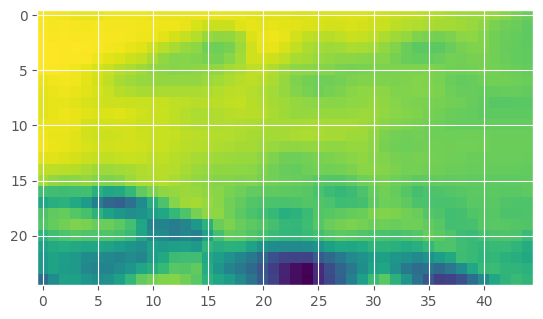

In [13]:
sample = X[0].reshape(num_latitudes, num_longitudes, num_features, INPUT_SIZE)
sample = sample[:,:,1,0]
plt.imshow(sample)
plt.show()

In [14]:
def node_index(i, j, num_cols):
    return i * num_cols + j

edge_index = []
for i in range(num_latitudes):
    for j in range(num_longitudes):
        if i > 0:
            edge_index.append([node_index(i, j, num_longitudes), node_index(i - 1, j, num_longitudes)])
        if j > 0:
            edge_index.append([node_index(i, j, num_longitudes), node_index(i, j - 1, num_longitudes)])
            
edge_index = torch.tensor(edge_index, dtype=torch.long).t()
print(edge_index.size())
edge_index = to_undirected(edge_index)
print(edge_index.size())

torch.Size([2, 2180])
torch.Size([2, 4360])


In [15]:
dataset = []
for i in range(X.shape[0]):
    Xi=torch.from_numpy(X[i].astype('float32')).to(device)
    yi=torch.from_numpy(y[i].astype('float32')).to(device)
    g = data.Data(x=Xi, edge_index=edge_index, y=yi)
    g = g.to(device)
    dataset.append(g)

dataset[100]

Data(x=[1125, 2, 4], edge_index=[2, 4360], y=[1125, 2, 1])

In [16]:
class TemporalGNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.output_dim = output_dim
        
        self.tgnn = A3TGCN(in_channels=input_dim,
                           out_channels=hidden_dim,
                           periods=output_dim)
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(hidden_dim, output_dim * input_dim)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index)
        h = F.relu(h)
        h = self.linear(h)
        return h.view(-1, x.size(1), self.output_dim)

hidden_dim = 2048
TemporalGNN(input_dim=num_features, hidden_dim=hidden_dim, output_dim=FH)

TemporalGNN(
  (tgnn): A3TGCN(
    (_base_tgcn): TGCN(
      (conv_z): GCNConv(2, 2048)
      (linear_z): Linear(in_features=4096, out_features=2048, bias=True)
      (conv_r): GCNConv(2, 2048)
      (linear_r): Linear(in_features=4096, out_features=2048, bias=True)
      (conv_h): GCNConv(2, 2048)
      (linear_h): Linear(in_features=4096, out_features=2048, bias=True)
    )
  )
  (linear): Linear(in_features=2048, out_features=2, bias=True)
)

In [17]:
model = TemporalGNN(input_dim=num_features, hidden_dim=hidden_dim, output_dim=FH)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()
criterion = criterion.to(device)
edge_index = edge_index.to(device)

train_data, val_data = dataset[:train_size], dataset[train_size:]
print("Number of train buckets: ", train_size)
print("Number of test buckets: ", val_size)

Number of train buckets:  999
Number of test buckets:  429


In [18]:
# y_hat.shape, batch.y.shape, batch.x.shape

In [19]:
start = time.time()
num_epochs = 100
subset = 10
val_loss_list = []
train_loss_list = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_data[:subset]:
        optimizer.zero_grad()
        y_hat = model(batch.x, batch.edge_index)
        # loss = criterion(y_hat, batch.y)
        loss = torch.sum((y_hat - batch.y)**2)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
            
    avg_loss = total_loss / train_size
    print(f"Epoch {epoch + 1}/{num_epochs}\nTrain Loss: {avg_loss:.4f}")
    train_loss_list.append(avg_loss)
    
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for batch in val_data[:subset]:
            y_hat = model(batch.x, batch.edge_index)
            # loss = criterion(y_hat, batch.y)
            loss = torch.sum((y_hat - batch.y)**2)
            val_loss += loss.item()
       
    avg_val_loss = val_loss / val_size
    print(f"Val Loss: {avg_val_loss:.4f}\n---------")
    val_loss_list.append(avg_val_loss)
    
end = time.time()
print(f'{end-start} [s]')

Epoch 1/100
Train Loss: 18.1850
Val Loss: 1.1768
---------
Epoch 2/100
Train Loss: 0.4023
Val Loss: 1.6683
---------
Epoch 3/100
Train Loss: 0.1514
Val Loss: 1.3332
---------
Epoch 4/100
Train Loss: 0.1767
Val Loss: 1.3701
---------
Epoch 5/100
Train Loss: 0.1181
Val Loss: 0.4849
---------
Epoch 6/100
Train Loss: 0.1819
Val Loss: 0.1534
---------
Epoch 7/100
Train Loss: 0.1585
Val Loss: 0.3582
---------
Epoch 8/100
Train Loss: 0.1033
Val Loss: 0.7009
---------
Epoch 9/100
Train Loss: 0.1038
Val Loss: 0.4062
---------
Epoch 10/100
Train Loss: 0.1639
Val Loss: 0.5701
---------
Epoch 11/100
Train Loss: 0.1748
Val Loss: 0.9865
---------
Epoch 12/100
Train Loss: 0.1758
Val Loss: 0.6003
---------
Epoch 13/100
Train Loss: 0.1755
Val Loss: 0.4072
---------
Epoch 14/100
Train Loss: 0.1658
Val Loss: 0.8836
---------
Epoch 15/100
Train Loss: 0.1353
Val Loss: 0.6368
---------
Epoch 16/100
Train Loss: 0.1049
Val Loss: 0.3324
---------
Epoch 17/100
Train Loss: 0.1272
Val Loss: 0.5902
---------
Epoch

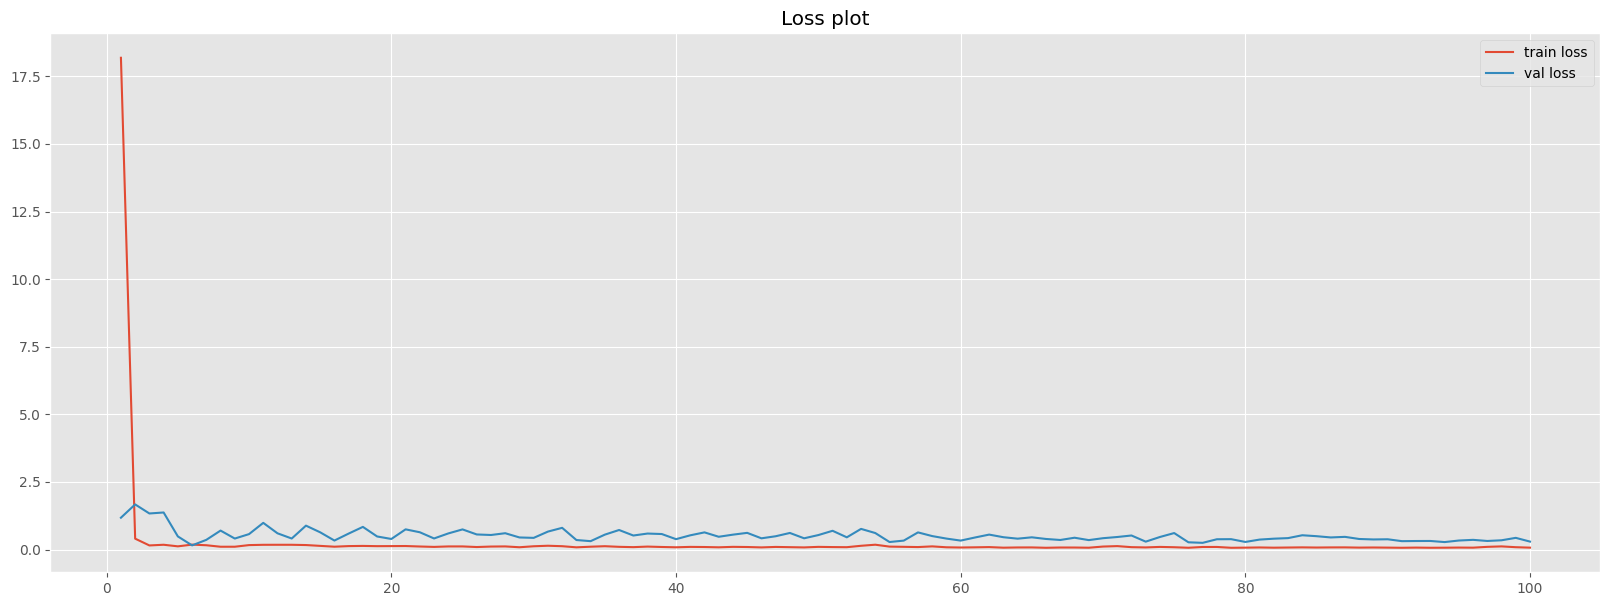

In [20]:
x = np.arange(1, len(train_loss_list)+1)
plt.figure(figsize=(20,7))
plt.plot(x, train_loss_list, label = 'train loss')
plt.plot(x, val_loss_list, label = 'val loss')
plt.title('Loss plot')
plt.legend()
plt.show()

MAE for 1 feature: 4.196816921234131
MAE for 2 feature: 1284.7816162109375


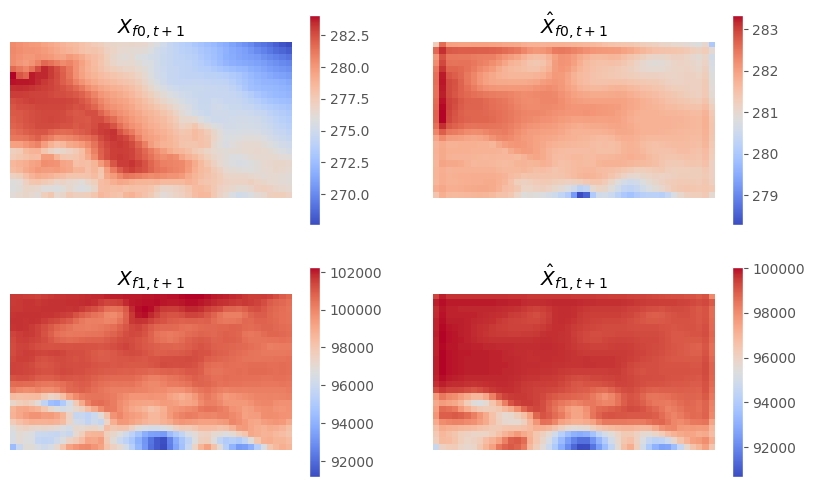

In [22]:
sample = train_data[0]
X = sample.x
y = sample.y
y = y.reshape((num_latitudes, num_longitudes, num_features, FH))
y = y.cpu().detach().numpy()

y_hat = model(X, edge_index)
y_hat = y_hat.reshape((num_latitudes, num_longitudes, num_features, FH))
y_hat = y_hat.cpu().detach().numpy()

yshape = (num_latitudes, num_longitudes, FH)

for i in range(num_features):
    yi = y[...,i,:].copy().reshape(-1,1)
    yhat_i = y_hat[...,i,:].copy().reshape(-1,1)
    
    y[...,i,:] = scalers[i].inverse_transform(yi).reshape(yshape)
    y_hat[...,i,:] = scalers[i].inverse_transform(yhat_i).reshape(yshape)

    
for i in range(num_features):
    loss = np.mean(np.abs(y_hat[...,i,:].reshape(-1,1) - y[...,i,:].reshape(-1,1)))
    print(f'MAE for {i+1} feature: {loss}')

    
fig, ax = plt.subplots(num_features, 2*FH, figsize=(10*FH, 3*num_features))

for j in range(num_features):
    cur_feature = f'f{j}'
    ts = 0
    for k in range(2*FH):
        if k % 3 == 0:
            title = rf"$X_{{{cur_feature},t+{ts+1}}}$"
            value = y[..., j,:]
            cmap = plt.cm.coolwarm
        elif k % 3 == 1:
            title = rf"$\hat{{X}}_{{{cur_feature},t+{ts+1}}}$"
            value = y_hat[..., j,:]
            cmap = plt.cm.coolwarm
       
        pl = ax[j, k].imshow(value.reshape(num_latitudes, num_longitudes), cmap=cmap)
        ax[j, k].set_title(title)
        ax[j, k].axis("off")
        _ = fig.colorbar(pl, ax=ax[j, k], fraction=0.15)


In [ ]:
# It has some potential I guess